## Analyse pricing des CAT Bounds 

In [20]:
# pip install basemap basemap-data-hires -q

In [21]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

from scipy import stats
from scipy.integrate import quad
from scipy.stats import ks_2samp
from scipy.optimize import minimize

from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from arch import arch_model

from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings("ignore")

In [22]:
n_annee = 4
threshold = 5
n_simulations = 10000

# DATA USA EARTHQUAKE
---

In [23]:
df = pd.read_csv('earthquake_state_.csv')
df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2025-04-14T17:08:28.110Z,33.035833,-116.594833,14.2900,5.21,mw,119.0,20.0,0.04508,0.21,...,2025-04-15T21:57:31.463Z,"5 km S of Julian, CA",earthquake,0.120000,0.300000,NaN,6.0,reviewed,ci,ci
1,2025-03-03T13:02:37.850Z,48.611167,-122.805167,15.8100,4.50,ml,82.0,31.0,0.00635,0.18,...,2025-04-14T13:12:43.341Z,"2025 Orcas Island, Washington",earthquake,0.140000,0.220000,0.201125,204.0,reviewed,uw,uw
2,2025-02-28T19:33:24.297Z,32.370000,-101.926000,6.8115,4.80,ml,43.0,41.0,0.00000,0.00,...,2025-04-05T16:45:40.543Z,"26 km SW of Ackerly, Texas",earthquake,0.489008,1.494629,0.200000,45.0,reviewed,tx,tx
3,2025-02-21T21:26:32.781Z,49.692800,-123.545400,10.0000,4.80,mww,37.0,45.0,0.95400,1.07,...,2025-04-04T05:29:31.512Z,"28 km W of Squamish, Canada",earthquake,3.690000,1.900000,0.052000,35.0,reviewed,us,us
4,2025-02-18T12:16:28.873Z,31.711000,-104.502000,3.8953,4.70,ml,6.0,110.0,0.00000,0.10,...,2025-04-15T12:26:38.054Z,"52 km SSW of Whites City, New Mexico",earthquake,0.598032,1.122082,0.100000,18.0,reviewed,tx,tx


In [24]:
df = pd.read_csv('earthquake_state_.csv') 
df = df[['time','latitude','longitude','depth','mag','place','locationSource','magSource']]
df["time"] = pd.to_datetime(df["time"])
df["year"] = df["time"].dt.year

def threshold_df(df, threshold) : 
    return df[df['mag'] > threshold]
df =threshold_df (df, threshold) 
summary_filtered = pd.DataFrame({
    "Variable": ["Magnitude (ML)"],
    "Moyenne": [
        df["mag"].mean()
    ],
    "Écart-type": [
        df["mag"].std()
    ],
    "Min": [
        df["mag"].min()
    ],
    "Max": [
        df["mag"].max()
    ],
    "Fréquence (n)": [
        df["mag"].count()/ (df["year"].max()-df["year"].min())
    ]
})

print(summary_filtered)
df.head()

         Variable   Moyenne  Écart-type   Min  Max  Fréquence (n)
0  Magnitude (ML)  5.579227    0.479357  5.01  7.9       8.758065


,time,latitude,longitude,depth,mag,place,locationSource,magSource,year
0,2025-04-14 17:08:28.110000+00:00,33.035833,-116.594833,14.2900,5.21,"5 km S of Julian, CA",ci,ci,2025
8,2024-12-09 23:08:31.577000+00:00,39.167500,-119.023800,9.3000,5.70,"2024 Parker Butte, Nevada Earthquake",nn,nn,2024
13,2024-09-17 00:49:42.183000+00:00,32.411000,-102.057000,6.1279,5.10,"2024 North of Tarzan, Texas Earthquake",tx,tx,2024
16,2024-08-07 04:09:56.760000+00:00,35.109000,-119.097000,11.6000,5.22,"24 km SW of Lamont, CA",ci,ci,2024
19,2024-07-26 14:28:29.143000+00:00,32.766000,-100.659000,3.2959,5.10,"17 km NNE of Hermleigh, Texas",tx,tx,2024


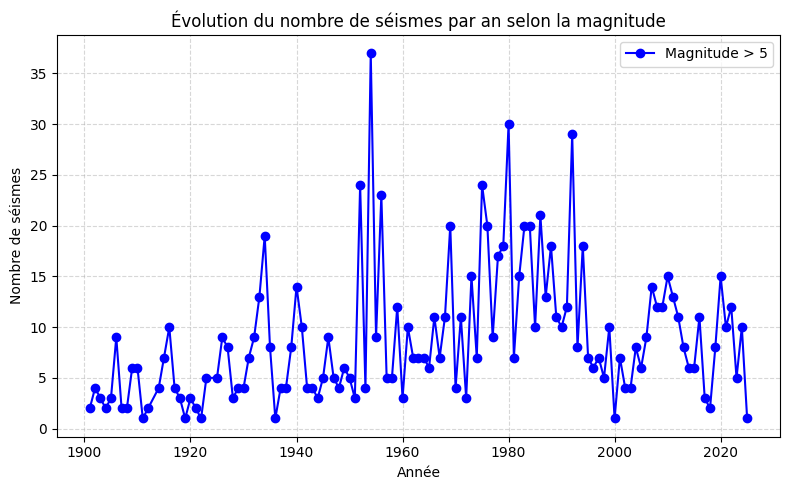

In [25]:
yearly_counts = df["year"].value_counts().sort_index()
plt.figure(figsize=(8, 5))
plt.plot(
    yearly_counts.index.astype(int),
    yearly_counts.values,
    marker='o',
    linestyle='-',
    color='blue',
    label=f'Magnitude > {threshold}'
)

plt.xlabel("Année")
plt.ylabel("Nombre de séismes")
plt.title("Évolution du nombre de séismes par an selon la magnitude")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


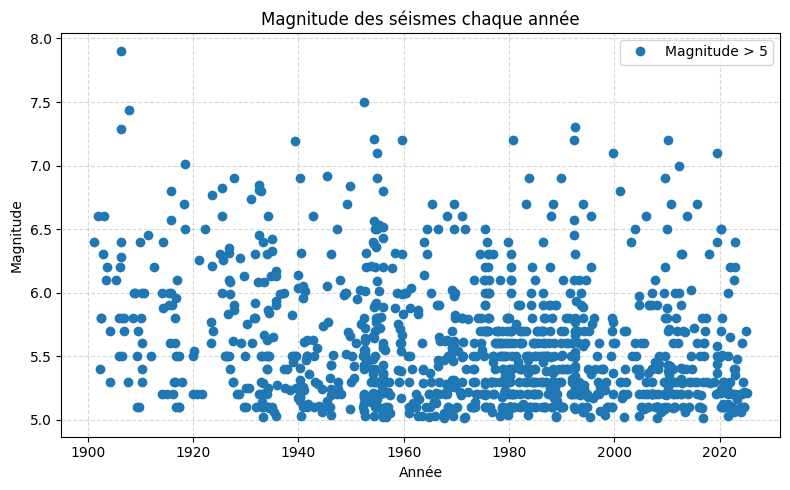

In [26]:
# Intensité des séismes 
plt.figure(figsize=(8, 5))
plt.plot(
    df['time'],
    df['mag'],
    marker='o',
    linestyle='',
    label=f'Magnitude > {threshold}'
)

plt.xlabel("Année")
plt.ylabel("Magnitude")
plt.title("Magnitude des séismes chaque année")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


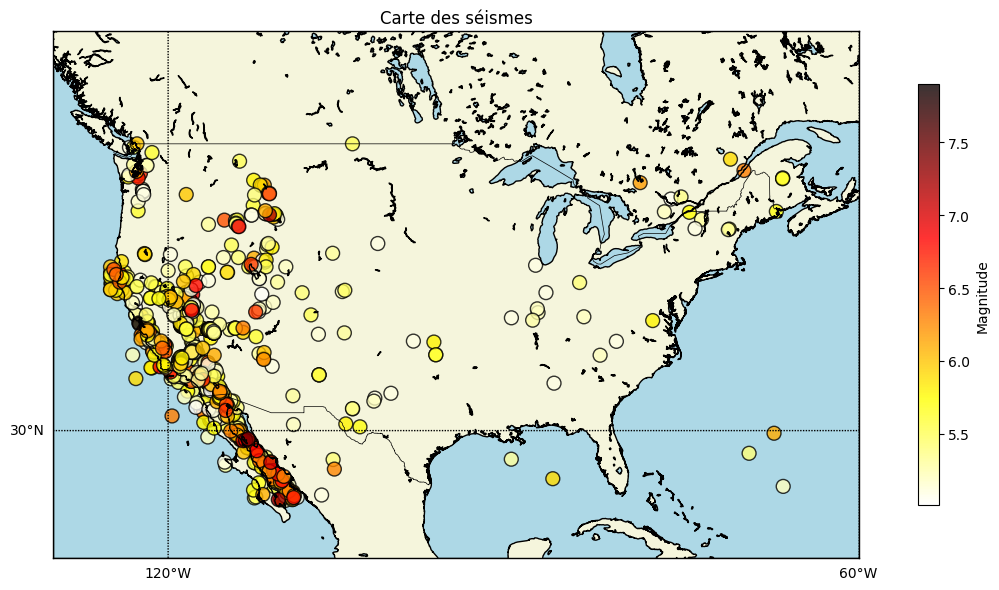

In [27]:
plt.figure(figsize=(12, 6))
m = Basemap(projection='merc', 
            llcrnrlat=20, urcrnrlat=55,  # latitude : de la Floride au nord des USA
            llcrnrlon=-130, urcrnrlon=-60,  # longitude : de la côte ouest à la côte est
            resolution='i') 

m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='lightblue')
m.fillcontinents(color='beige', lake_color='lightblue')
m.drawparallels(np.arange(-90., 91., 30.), labels=[1,0,0,0])
m.drawmeridians(np.arange(-180., 181., 60.), labels=[0,0,0,1])

# Projection des points
lons, lats = df["longitude"].values, df["latitude"].values
x, y = m(lons, lats)

# Couleurs en fonction des magnitudes
sc = plt.scatter(x, y, c=df["mag"], cmap='hot_r', s=100, edgecolor='k', alpha=0.8)

# Ajouter une barre de couleur
cbar = plt.colorbar(sc, orientation='vertical', shrink=0.8, pad=0.05)
cbar.set_label("Magnitude")

# Titres
plt.title("Carte des séismes")
plt.tight_layout()
plt.show()

# MODELISATION

#### Estimation de lambda

T : 124.12, lambda : 8.75 


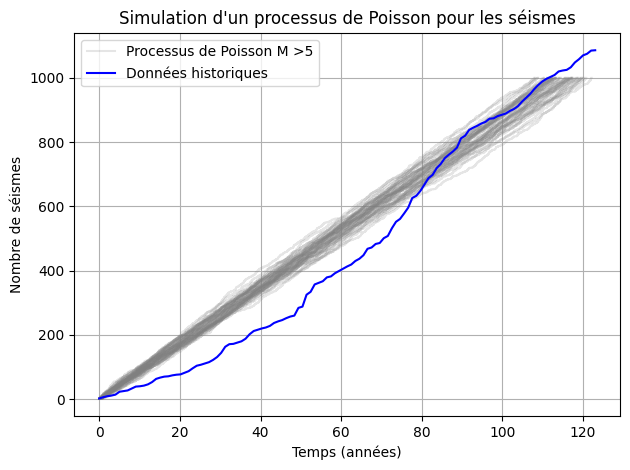

In [28]:
T = (df['time'].max() - df['time'].min()).total_seconds() / (365.25 * 24 * 60 * 60)
lambda_rate = len(df)/T
print(f'T : {T:.2f}, lambda : {lambda_rate:.2f} ')

def generate_process(lambda_rate, t) : 
    tau = np.random.exponential(1/lambda_rate, size=1000)
    Tn = np.cumsum(tau)

    Tn = Tn[Tn < t]
    N_t = np.arange(1, len(Tn)+1)
    return Tn, N_t

data_histo = np.cumsum(yearly_counts.values)
t_ = len(data_histo)
for k in range (50): 
    plt.step(*generate_process(lambda_rate, t= t_), where='post',color='gray', alpha=0.2)
    plt.xlabel('Temps (années)')
    plt.ylabel('Nombre de séismes')
    plt.title("Simulation d'un processus de Poisson pour les séismes")
    plt.grid(True)
    plt.tight_layout()
plt.step(*generate_process(lambda_rate, t= t_), where='post',color='gray', alpha=0.2, label = f"Processus de Poisson M >{threshold}")
plt.plot(np.linspace(0,t_, t_),data_histo, color = 'blue', label = "Données historiques")
plt.legend()
plt.show()

8.688
Taux moyen estimé λ : 8.69 séismes/an


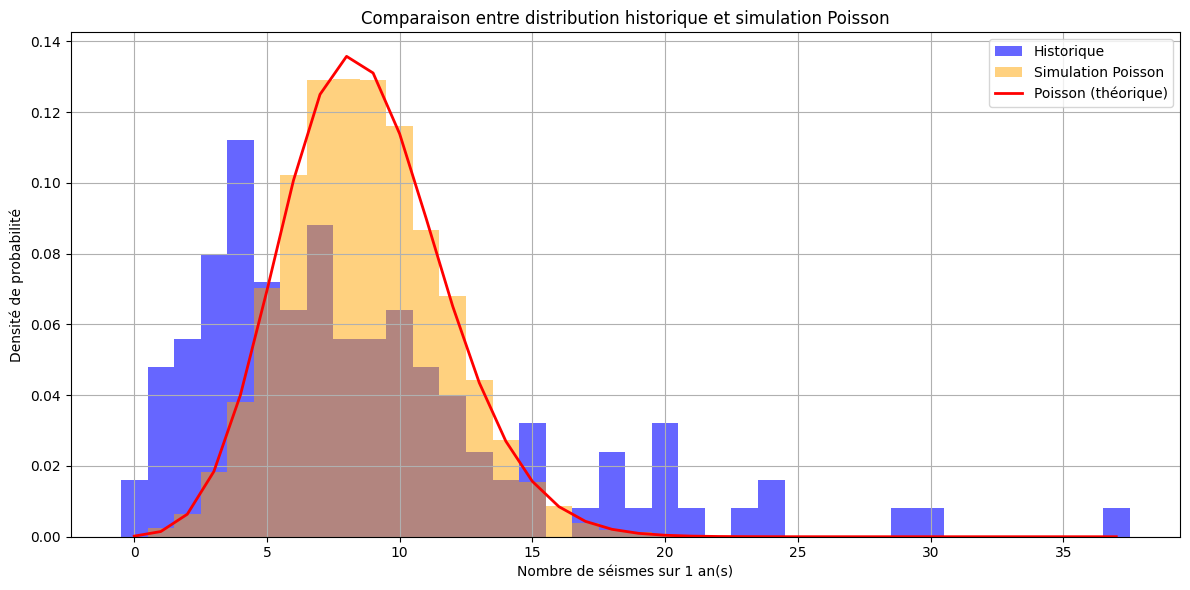

Test KS → Statistique : 0.248, p-value : 0.0000
❌ Différence significative entre les deux distributions (H0 rejetée)


In [29]:
# Paramètres
n_annee = 1
n_simulations = 10000

# Prétraitement
df['time'] = pd.to_datetime(df['time'])
df['year'] = df['time'].dt.year
start_year = df['year'].min()
end_year = df['year'].max() - n_annee + 1

# Compte des séismes par fenêtre glissante d’un an
window_counts = []
for start in range(start_year, end_year + 1):
    end = start + n_annee
    count = df[(df['year'] >= start) & (df['year'] < end)].shape[0]
    window_counts.append(count)
window_counts = np.array(window_counts)

# Estimation du taux moyen λ
lambda_hat = np.mean(window_counts) / n_annee
print(lambda_hat)
print(f"Taux moyen estimé λ : {lambda_hat:.2f} séismes/an")

# Simulation d'une distribution de Poisson
simulated_counts = np.random.poisson(lam=lambda_hat * n_annee, size=n_simulations)

# Visualisation
plt.figure(figsize=(12, 6))
bins_range = np.arange(min(min(window_counts), min(simulated_counts)) - 0.5,
                       max(max(window_counts), max(simulated_counts)) + 1.5, 1)
plt.hist(window_counts, bins=bins_range, alpha=0.6, label="Historique", color='blue', density=True)
plt.hist(simulated_counts, bins=bins_range, alpha=0.5, label="Simulation Poisson", color='orange', density=True)
plt.plot(np.arange(0, bins_range.max()), 
         stats.poisson.pmf(np.arange(0, bins_range.max()), mu=lambda_hat),
         'r-', label="Poisson (théorique)", linewidth=2)
plt.xlabel(f"Nombre de séismes sur {n_annee} an(s)")
plt.ylabel("Densité de probabilité")
plt.title("Comparaison entre distribution historique et simulation Poisson")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Test KS : uniquement entre deux échantillons
ks_stat, p_value = ks_2samp(window_counts, simulated_counts)
print(f"Test KS → Statistique : {ks_stat:.3f}, p-value : {p_value:.4f}")

if p_value > 0.05:
    print("✅ Aucune différence significative détectée (H0 non rejetée)")
else:
    print("❌ Différence significative entre les deux distributions (H0 rejetée)")


In [30]:
df_ = df[['year', 'mag']].copy()
period = 1
df_['period'] = (df_['year'] // period) * period  
freq_col = 'freq_eathquake'
data = df_.groupby("period")["mag"].apply(lambda x: (x > 5).sum())
df_freq = pd.DataFrame(data).reset_index()
df_freq.columns = ['period', freq_col]
min_period = df_freq['period'].min()
max_period = 2025



# Créer un Series avec un nom
all_periods = pd.Series(range(min_period, max_period + 1), name='period')
df_freq= pd.merge(all_periods.to_frame(), df_freq, how='left', on='period')
df_freq[freq_col].fillna(0, inplace=True)
df_freq.columns = ['period', freq_col]
#df_freq = df_freq[df_freq['period']%2 == 0]
#df_freq['Delta'] = abs(df_freq['freq_eathquake'].diff())
#print(df_freq['Delta'].mean())
print(df_freq)

     period  freq_eathquake
0      1901             2.0
1      1902             4.0
2      1903             3.0
3      1904             2.0
4      1905             3.0
..      ...             ...
120    2021            10.0
121    2022            12.0
122    2023             5.0
123    2024            10.0
124    2025             1.0

[125 rows x 2 columns]


ADF Statistic: -4.1669
p-value: 0.0007
→ Série STATIONNAIRE → test de modèles ARMA(p,q), i.e. ARIMA(p,0,q)


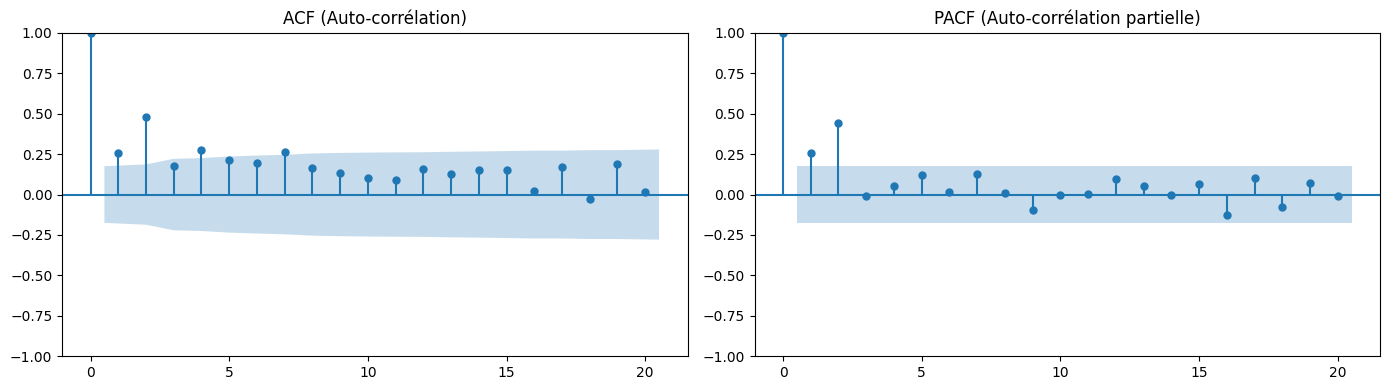

ARIMA(0, 0, 0) → AIC = 831.28, BIC = 836.93
ARIMA(0, 0, 1) → AIC = 828.77, BIC = 837.25
ARIMA(0, 0, 2) → AIC = 806.87, BIC = 818.18
ARIMA(0, 0, 3) → AIC = 808.47, BIC = 822.61
ARIMA(1, 0, 0) → AIC = 824.60, BIC = 833.09
ARIMA(1, 0, 1) → AIC = 808.23, BIC = 819.54
ARIMA(1, 0, 2) → AIC = 806.47, BIC = 820.61
ARIMA(1, 0, 3) → AIC = 802.07, BIC = 819.04
ARIMA(2, 0, 0) → AIC = 799.26, BIC = 810.57
ARIMA(2, 0, 1) → AIC = 801.26, BIC = 815.40
ARIMA(2, 0, 2) → AIC = 802.83, BIC = 819.80
ARIMA(2, 0, 3) → AIC = 802.11, BIC = 821.91
ARIMA(3, 0, 0) → AIC = 801.26, BIC = 815.40
ARIMA(3, 0, 1) → AIC = 803.25, BIC = 820.22
ARIMA(3, 0, 2) → AIC = 802.73, BIC = 822.52
ARIMA(3, 0, 3) → AIC = 803.47, BIC = 826.09

✅ Meilleur modèle sélectionné : ARMA(2, 0, 0) avec AIC = 799.26
                               SARIMAX Results                                
Dep. Variable:         freq_eathquake   No. Observations:                  125
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -39

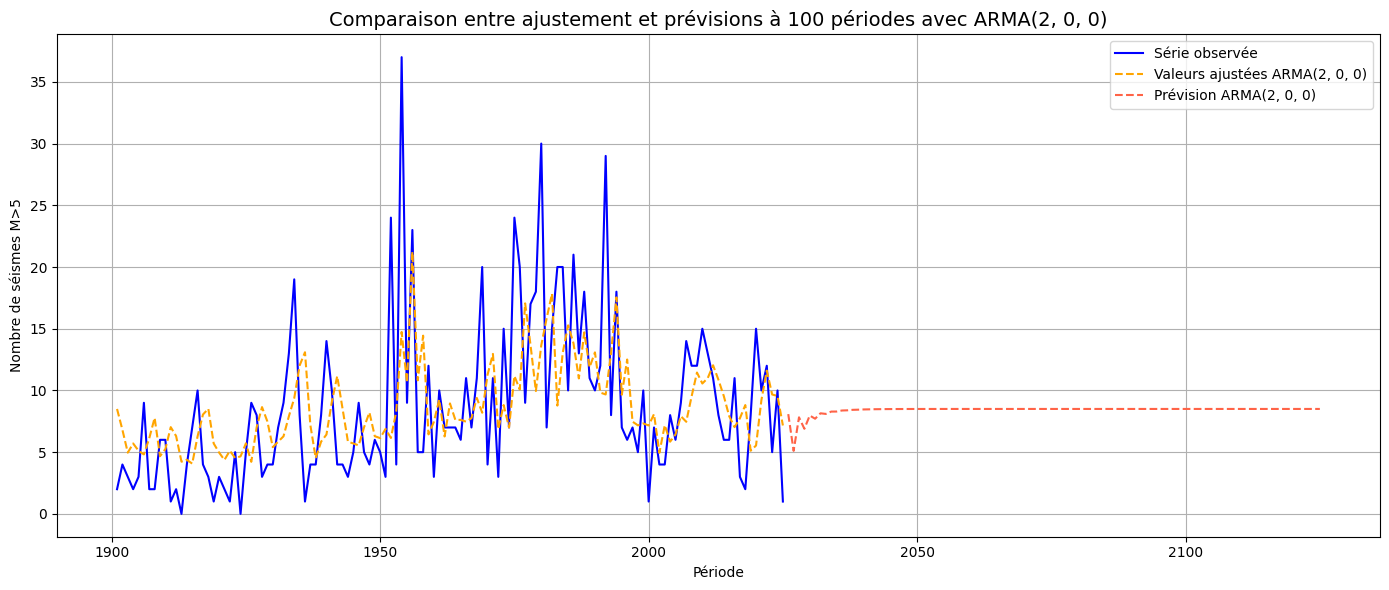

In [31]:
# Série temporelle indexée par période
time_series = df_freq.set_index('period')[freq_col].astype(float)

adf_stat, p_value, _, _, _, _ = adfuller(time_series)
print(f"ADF Statistic: {adf_stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value > 0.05:
    print("→ Série NON stationnaire → test de modèles ARIMA(p,d,q) avec d ∈ [1, 2]")
    d_values = [1, 2]
else:
    print("→ Série STATIONNAIRE → test de modèles ARMA(p,q), i.e. ARIMA(p,0,q)")
    d_values = [0]

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
sm.graphics.tsa.plot_acf(time_series, lags=20, ax=axes[0])
sm.graphics.tsa.plot_pacf(time_series, lags=20, ax=axes[1])
axes[0].set_title("ACF (Auto-corrélation)")
axes[1].set_title("PACF (Auto-corrélation partielle)")
plt.tight_layout()
plt.show()

model_results = []

# Tester tous les (p,d,q) avec p,q ∈ [0,3] et d choisi dynamiquement
for p in range(0, 4):
    for d in d_values:
        for q in range(0, 4):
            try:
                model = ARIMA(time_series, order=(p, d, q))
                result = model.fit()
                model_results.append({
                    'order': (p, d, q),
                    'aic': result.aic,
                    'bic': result.bic,
                    'model': result
                })
                print(f"ARIMA{(p,d,q)} → AIC = {result.aic:.2f}, BIC = {result.bic:.2f}")
            except Exception as e:
                print(f"❌ Échec ARIMA{(p,d,q)} : {e}")

# Trier par AIC croissant
sorted_models = sorted(model_results, key=lambda x: x['aic'])
best_model_info = sorted_models[0]
best_order = best_model_info['order']
best_model = best_model_info['model']

model_type = "ARMA" if best_order[1] == 0 else "ARIMA"
print(f"\n✅ Meilleur modèle sélectionné : {model_type}{best_order} avec AIC = {best_model_info['aic']:.2f}")
print(best_model.summary())

n_steps = 100  # Nombre de périodes à prévoir
forecast = best_model.get_forecast(steps=n_steps)
forecast_values_arima = forecast.predicted_mean
forecast_index = np.arange(time_series.index.max() + 1, time_series.index.max() + 1 + n_steps)

# Valeurs ajustées (fitted values) du modèle
fitted_values = best_model.fittedvalues

# Visualisation de la série réelle, des valeurs ajustées et des prévisions
plt.figure(figsize=(14, 6))
plt.plot(time_series, label='Série observée', color='blue')
plt.plot(time_series.index, fitted_values, label=f'Valeurs ajustées {model_type}{best_order}', color='orange', linestyle='--')
plt.plot(forecast_index, forecast_values_arima, label=f'Prévision {model_type}{best_order}', linestyle='--', color='tomato')
plt.title(f'Comparaison entre ajustement et prévisions à {n_steps} périodes avec {model_type}{best_order}', fontsize=14)
plt.xlabel('Période')
plt.ylabel(f'Nombre de séismes M>{threshold}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:
print('lambda AR(I)MA = ',list(forecast_values_arima)[-1])

lambda AR(I)MA =  8.501403392917492


ADF Statistic: -4.1669
p-value: 0.0007
✅ Série STATIONNAIRE – OK pour GARCH


                     Constant Mean - GARCH Model Results                      
Dep. Variable:         freq_eathquake   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -407.641
Distribution:                  Normal   AIC:                           823.283
Method:            Maximum Likelihood   BIC:                           834.596
                                        No. Observations:                  125
Date:                Tue, May 06 2025   Df Residuals:                      124
Time:                        17:29:24   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             7.0715      1.251      5.654  1.564e-08 [  4.620,  9.52

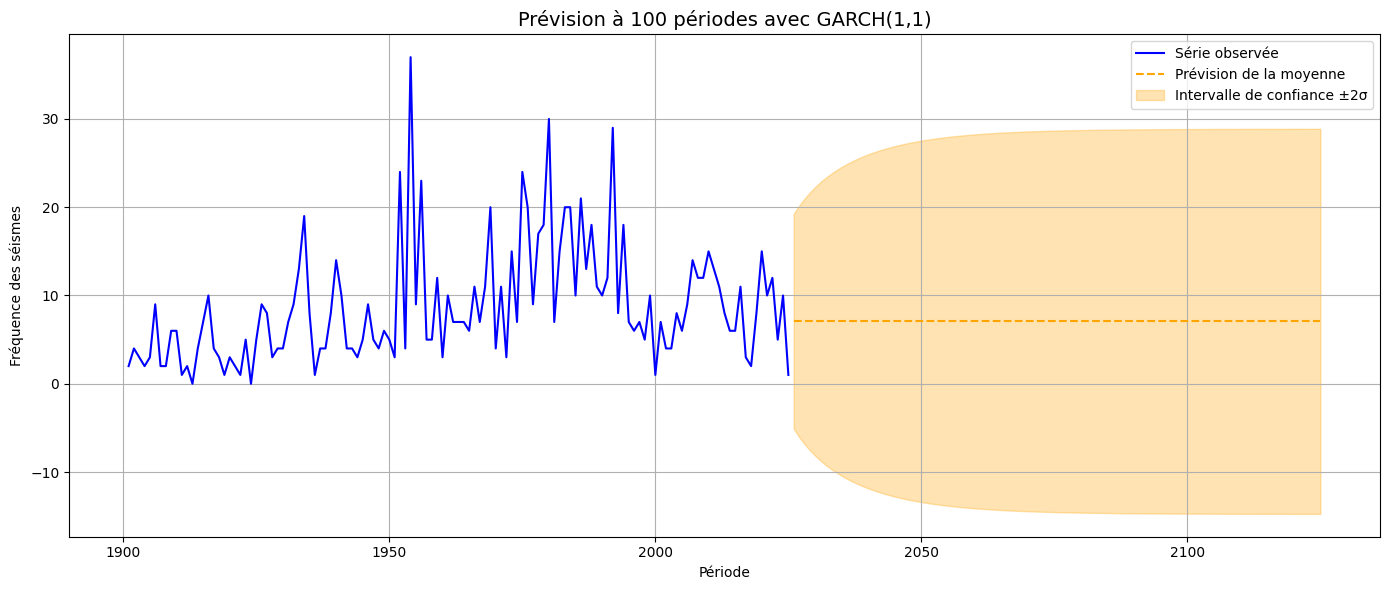

In [33]:
time_series = df_freq.set_index('period')[freq_col].astype(float)

adf_stat, p_value, _, _, _, _ = adfuller(time_series)
print(f"ADF Statistic: {adf_stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value > 0.05:
    print("⚠️ Série NON stationnaire – différenciation appliquée")
    time_series = time_series.diff().dropna()
else:
    print("✅ Série STATIONNAIRE – OK pour GARCH")

garch_model = arch_model(time_series, vol='Garch', p=1, q=1, mean='Constant', dist='normal')
garch_result = garch_model.fit(disp='off')
print(garch_result.summary())


n_forecast = 100  
forecast = garch_result.forecast(horizon=n_forecast)
forecast_value_garch = forecast.mean.values[-1, :]
variance_forecast = forecast.variance.values[-1, :]
forecast_index = np.arange(time_series.index.max() + 1, time_series.index.max() + 1 + n_forecast)


plt.figure(figsize=(14, 6))
plt.plot(time_series, label='Série observée', color='blue')
plt.plot(forecast_index, forecast_value_garch, label='Prévision de la moyenne', color='orange', linestyle='--')
plt.fill_between(forecast_index,
                 forecast_value_garch - 2*np.sqrt(variance_forecast),
                 forecast_value_garch + 2*np.sqrt(variance_forecast),
                 color='orange', alpha=0.3, label='Intervalle de confiance ±2σ')
plt.title(f'Prévision à {n_forecast} périodes avec GARCH(1,1)', fontsize=14)
plt.xlabel('Période')
plt.ylabel('Fréquence des séismes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Estimation de la distribution de la queue de distribution par la TVE

Paramètres estimés : xi = -0.1888, loc = 0.0100, sigma = 0.6758


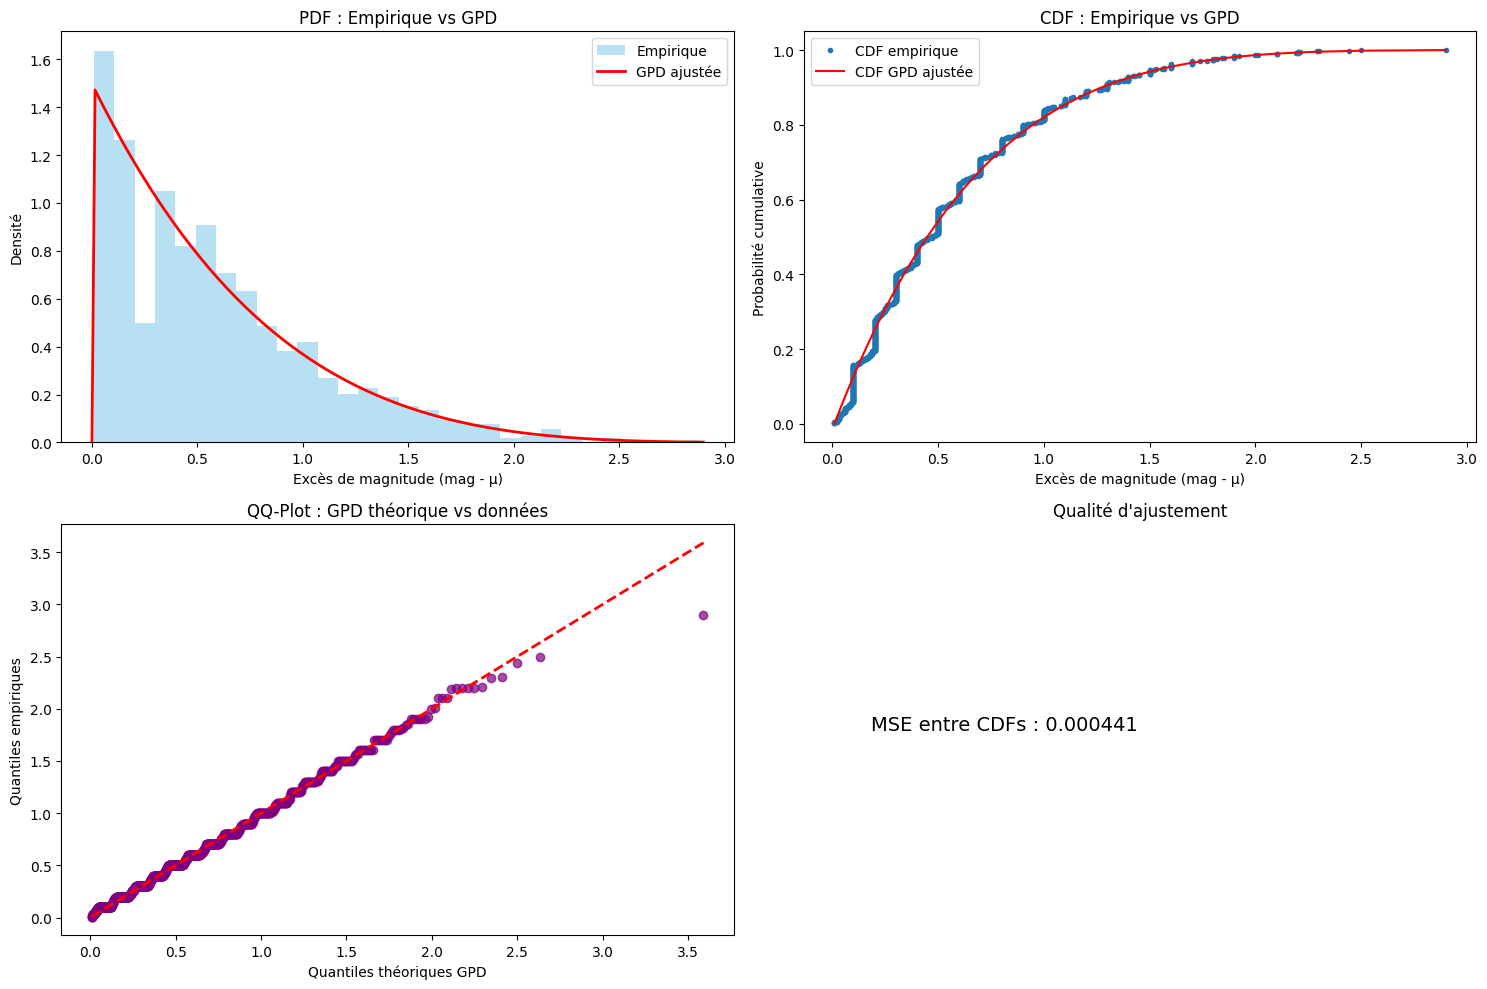

✅ Mean Squared Error (MSE) entre CDF empirique et GPD = 0.000441
✅ Cramer–von Mises statistic = 0.4824, p-value = 0.0441
✅ Hypothèse nulle acceptée au niveau 4% : la GPD ajuste correctement les excès


In [34]:
magnitudes = df['mag'].values
excesses = magnitudes- threshold
xi, loc, sigma = stats.genpareto.fit(excesses)
print(f"Paramètres estimés : xi = {xi:.4f}, loc = {loc:.4f}, sigma = {sigma:.4f}")

x_vals = np.linspace(0, excesses.max(), 200)
pdf_gpd = stats.genpareto.pdf(x_vals, c=xi, loc=loc, scale=sigma)

plt.figure(figsize=(15, 10))

# Histogramme + PDF
plt.subplot(2, 2, 1)
plt.hist(excesses, bins=30, density=True, alpha=0.6, color='skyblue', label="Empirique")
plt.plot(x_vals, pdf_gpd, 'r-', lw=2, label='GPD ajustée')
plt.title("PDF : Empirique vs GPD")
plt.xlabel("Excès de magnitude (mag - μ)")
plt.ylabel("Densité")
plt.legend()

# CDF
ecdf = np.sort(excesses)
empirical_cdf = np.arange(1, len(ecdf)+1) / len(ecdf)
cdf_gpd = stats.genpareto.cdf(ecdf, c=xi, loc=loc, scale=sigma)

plt.subplot(2, 2, 2)
plt.plot(ecdf, empirical_cdf, marker='.', linestyle='none', label="CDF empirique")
plt.plot(ecdf, cdf_gpd, 'r-', label="CDF GPD ajustée")
plt.title("CDF : Empirique vs GPD")
plt.xlabel("Excès de magnitude (mag - μ)")
plt.ylabel("Probabilité cumulative")
plt.legend()

# QQ-Plot
theoretical_quantiles = stats.genpareto.ppf(empirical_cdf, c=xi, loc=loc, scale=sigma)
plt.subplot(2, 2, 3)
plt.scatter(theoretical_quantiles, ecdf, color='purple', alpha=0.7)
plt.plot([theoretical_quantiles.min(), theoretical_quantiles.max()],
         [theoretical_quantiles.min(), theoretical_quantiles.max()],
         'r--', lw=2)
plt.title("QQ-Plot : GPD théorique vs données")
plt.xlabel("Quantiles théoriques GPD")
plt.ylabel("Quantiles empiriques")

# Résumé erreurs
mse_cdf = mean_squared_error(empirical_cdf, cdf_gpd)
plt.subplot(2, 2, 4)
plt.text(0.1, 0.5, f"MSE entre CDFs : {mse_cdf:.6f}", fontsize=14)
plt.axis('off')
plt.title("Qualité d'ajustement")

plt.tight_layout()
plt.show()

# Résultat final
print(f"✅ Mean Squared Error (MSE) entre CDF empirique et GPD = {mse_cdf:.6f}")

# Transformation via la CDF
transformed = stats.genpareto.cdf(excesses, c=xi, loc=loc, scale=sigma)

# Test Cramér–von Mises pour l'uniformité
cvm_result = stats.cramervonmises(transformed, 'uniform')

print(f"✅ Cramer–von Mises statistic = {cvm_result.statistic:.4f}, p-value = {cvm_result.pvalue:.4f}")

if cvm_result.pvalue > 0.04:
    print("✅ Hypothèse nulle acceptée au niveau 4% : la GPD ajuste correctement les excès")
else:
    print("❌ Hypothèse nulle rejetée au niveau 4% : la GPD ajuste mal les excès")


Après ajustement de la loi de Pareto généralisée (GPD) aux excès de magnitude, les résultats montrent une excellente adéquation. Graphiquement, la densité et la fonction de répartition théorique épousent de très près les données empiriques, ce qui est confirmé par un QQ-plot aligné presque parfaitement sur la diagonale. Numériquement, l'erreur quadratique moyenne (MSE) entre la CDF empirique et la CDF ajustée est extrêmement faible (0.000441), attestant de la qualité de l'ajustement. Bien que les tests statistiques comme Anderson–Darling soient très sensibles et mènent ici au rejet de l'hypothèse nulle, cette décision est davantage liée à leur nature stricte qu'à un véritable écart substantiel. Ainsi, tant du point de vue visuel que quantitatif, le modèle GPD s'avère adapté pour modéliser les extrêmes de magnitude.



# USA IR analysis

In [8]:
import numpy  as np 
A = np.random.rand(4,3)
np.sum(A, axis = 1, keepdims=True).shape

(4, 1)

In [35]:
rate_df = pd.read_csv('FEDFUNDS.csv')
dt = 1/12 # On rapporte à une période annuelle 
r0 = rate_df['FEDFUNDS'].iloc[-1]
T = 10
dt = 1/12
N = int(T / dt)
M = 100
rate_df.head()

,observation_date,FEDFUNDS
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83


0.6487632757752393
Prix théorique du Zero-Coupon Bond : 0.64876
Prix estimé par Monte Carlo du Zero-Coupon Bond : 0.64240


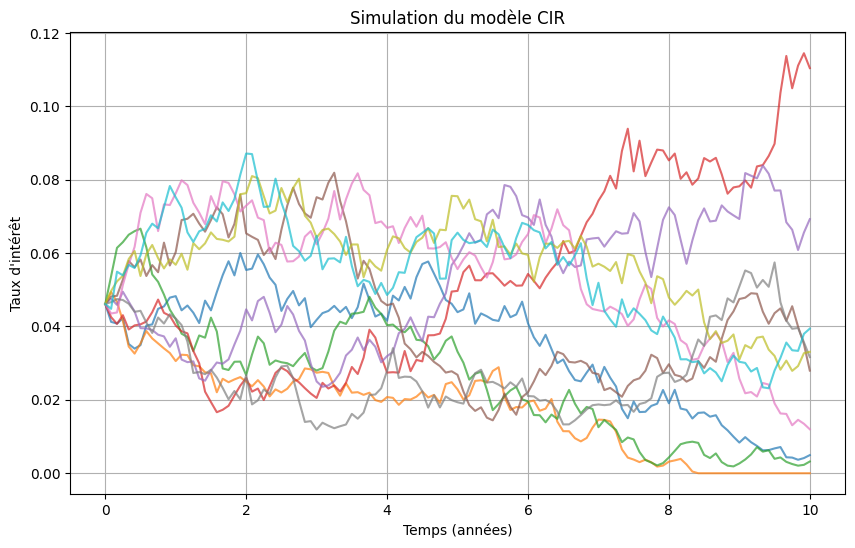

In [36]:
# Calcul des fonctions A(t,T) et B(t,T)
def A(t, T, kappa, theta, sigma):
    gamma = np.sqrt(kappa**2 + 2 * sigma**2)
    num = 2 * gamma * np.exp((gamma+kappa)* (T - t)/2)
    den = (kappa + gamma) * (np.exp(gamma * (T - t)) - 1) + 2 * gamma
    return (num / den) ** (2 * kappa * theta / sigma**2)

def B(t, T, kappa, sigma):
    gamma = np.sqrt(kappa**2 + 2 * sigma**2)
    num = 2 * (np.exp(gamma * (T - t)) - 1)
    den = (kappa + gamma) * (np.exp(gamma * (T - t)) - 1) + 2 * gamma
    return num / den

def BCIR(t, T, kappa, theta, sigma, r0) : 
    # Calcul du prix du zero-coupon bond par méthode théorique
    A_t_T = A(t, T, kappa, theta, sigma)
    B_t_T = B(t, T, kappa, sigma)
    zero_coupon_bond_price_theoretical = A_t_T * np.exp(-B_t_T * r0)
    return zero_coupon_bond_price_theoretical



# Fonction de simulation CIR
def simulate_CIR(kappa, theta, sigma, r0, T, dt, N, M):
    rates = np.zeros((M, N+1))
    rates[:, 0] = r0
    for i in range(1, N+1):
        dW = np.random.normal(0, np.sqrt(dt), M)
        dr = kappa * (theta - rates[:, i-1]) * dt + sigma * np.sqrt(np.maximum(rates[:, i-1], 0)) * dW
        rates[:, i] = rates[:, i-1] + dr
    return rates


def cir_log_likelihood(params, r, dt):
    kappa, theta, sigma = params
    n = len(r)
    loglik = 0
    for i in range(1, n):
        rt_prev = r[i - 1]
        delta_r = r[i] - rt_prev
        mu = kappa * (theta - rt_prev) * dt
        var = sigma**2 * rt_prev * dt
        if var <= 0: var = 1e-6
        loglik += -0.5 * np.log(2 * np.pi * var) - (delta_r - mu)**2 / (2 * var)
    return -loglik  # on minimise donc on renvoie -vraisemblance

# Estimation des paramètres par MLE 
initial_guess = [0.5, 0.02, 0.01]  # kappa, theta, sigma
bounds = [(1e-4, 5), (1e-4, 0.5), (1e-6, 1)]


result = minimize(cir_log_likelihood, initial_guess, args=(rate_df['FEDFUNDS']/100 , dt), bounds=bounds)
kappa_hat, theta_hat, sigma_hat = result.x 
r0 = rate_df['FEDFUNDS'].mean()/100
zero_coupon_bond_price_theoretical =  BCIR(0, T, kappa_hat , theta_hat, sigma_hat, r0)


dt = T/N
# Simulation des trajectoires de taux
rates = simulate_CIR(kappa_hat, theta_hat, sigma_hat , r0, T, dt, N, M)

# Calcul de l'intégrale de r(t) sur [t, T] pour chaque trajectoire
integrals = np.sum(rates[:, 1:] * dt, axis=1)
zero_coupon_bond_price_MC = np.mean(np.exp(-integrals))  

# Affichage des résultats
print(zero_coupon_bond_price_theoretical)
print(f'Prix théorique du Zero-Coupon Bond : {zero_coupon_bond_price_theoretical:.5f}')
print(f'Prix estimé par Monte Carlo du Zero-Coupon Bond : {zero_coupon_bond_price_MC:.5f}')


time = np.linspace(0, T, N+1)
plt.figure(figsize=(10,6))
for i in range(M//10):
    plt.plot(time, rates[i], alpha=0.7)
plt.xlabel('Temps (années)')
plt.ylabel('Taux d\'intérêt')
plt.title('Simulation du modèle CIR')
plt.grid(True)
plt.show()



In [37]:
print(f"kappa_hat: {kappa_hat:.2e}, sigma_hat : {sigma_hat:.2e}, theta_hat: {theta_hat:.2e}")

kappa_hat: 1.00e-04, sigma_hat : 6.26e-02, theta_hat: 1.04e-04


# Pricing de l'OZC

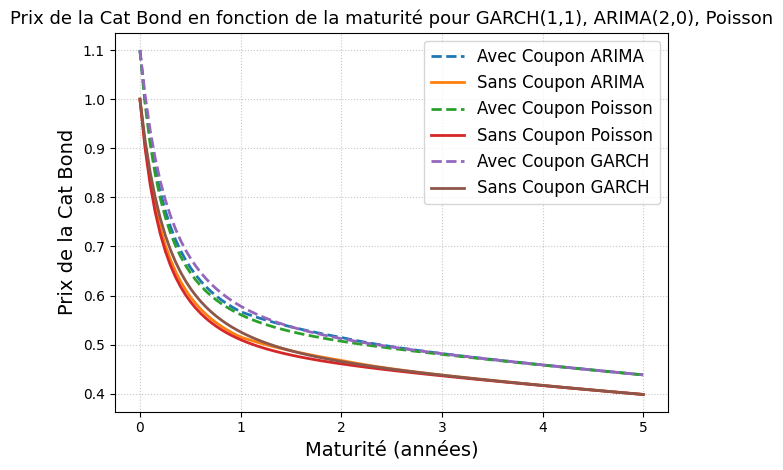

In [38]:
lambda_func_poisson = lambda t: lambda_rate
lambda_func_arima = lambda t: forecast_values_arima.reset_index(drop=True)[int(t)]
lambda_func_garch= lambda t: forecast_value_garch[int(t)]

def poisson_intensity(t0, T, lambda_func):
    integral, _ = quad(lambda_func, t0, T)
    return integral

loc = 0
xi_earthquake = 0.2
sigma_earthquake = 1.5
mu_earthquake = threshold + loc  

def P_M_le_d(d, mu, xi, sigma, m_intensity):
    if xi != 0:
        return np.exp(-m_intensity * (1 + xi * (d - mu) / sigma) ** (-1 / xi))
    else:
        return np.exp(-m_intensity * np.exp(-(d - mu) / sigma))

#  Paramètres du taux CIR 
r0_rate = r0
kappa_rate = kappa_hat
theta_rate = theta_hat
sigma_rate = sigma_hat


# Données de la cat bond 
K = 1
C = 0.1
eta = [1, 0.875, 0.75, 0.625, 0.5]
d = [5.0, 6.0, 7.0, 8.0]


def price_cat_bond_analytic(mu, xi, sigma, lambda_func, r0, T, K, eta, d, kappa, theta, sigma_rate):
    m = poisson_intensity(0, T, lambda_func)
    prob_parts = [P_M_le_d(di, mu, xi, sigma, m) for di in d]

    sum_part = 0
    for i in range(len(d)):
        delta_eta = eta[i] - eta[i + 1]
        sum_part += delta_eta * prob_parts[i]
    
    final_term = eta[-1]
    discount = BCIR(0, T, kappa, theta, sigma_rate, r0)
    price = discount * K * (final_term + sum_part)
    return price

def price_cat_bond_analytic_with_coupon(mu, xi, sigma, lambda_func, r0, T, K, eta, d, C, kappa, theta, sigma_rate):
    m = poisson_intensity(0, T, lambda_func)
    prob_parts = [P_M_le_d(di, mu, xi, sigma, m) for di in d]

    sum_part = 0
    for i in range(len(d)):
        delta_eta = eta[i] - eta[i + 1]
        sum_part += delta_eta * prob_parts[i]
    
    final_term = eta[-1]
    discount = BCIR(0, T, kappa, theta, sigma_rate, r0)
    price = discount * (K + C) * (final_term + sum_part)
    return price



T = np.linspace (0,5,100)
dico = {
    'ARIMA': lambda_func_arima,
    'Poisson' : lambda_func_poisson,
    'GARCH': lambda_func_garch}

    
List_lambda_func = [lambda_func_arima, lambda_func_poisson]
for key in dico.keys():
    bond_price_list = []
    bond_price_with_coupon_list = []
    maturity = []
    for t in T: 
        bond_price = price_cat_bond_analytic(
            mu_earthquake, xi_earthquake, sigma_earthquake, dico[key],
            r0_rate, t, K, eta, d,
            kappa_rate, theta_rate, sigma_rate
        )
        bond_price_list.append(bond_price)
        bond_price_with_coupon = price_cat_bond_analytic_with_coupon(
            mu_earthquake, xi_earthquake, sigma_earthquake, dico[key],
            r0_rate, t, K, eta, d, C,
            kappa_rate, theta_rate, sigma_rate
        )
        bond_price_with_coupon_list.append(bond_price_with_coupon)
        maturity.append(t)
    
    
    plt.plot(maturity, bond_price_with_coupon_list, label=f'Avec Coupon {key}', linestyle='--', linewidth=2)
    plt.plot(maturity, bond_price_list, label=f'Sans Coupon {key}', linestyle='-', linewidth=2)
    plt.title(f'Prix de la Cat Bond en fonction de la maturité pour GARCH(1,1), ARIMA(2,0), Poisson', fontsize=13)
    plt.xlabel('Maturité (années)', fontsize=14)
    plt.ylabel('Prix de la Cat Bond', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.tight_layout()
plt.show()
